In [1]:
'''Comparing estimation using the hospitalization data vs the new hospitalization data.'''

'Comparing estimation using the hospitalization data vs the new hospitalization data.'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from epymorph.kit import *
from epymorph.adrio import acs5

from epymorph.adrio import us_tiger

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.forecasting.likelihood import Poisson
from epymorph.forecasting.dynamic_params import OrnsteinUhlenbeck
from epymorph.forecasting.dynamic_params import GaussianPrior
from epymorph.forecasting.param_transformations import ExponentialTransform

from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.time import EveryNDays

In [3]:
from typing_extensions import override
from epymorph.initializer import _POPULATION_ATTR
from epymorph.initializer import *

class RandomLocationsAndRandomSeed(SeededInfection):
    """
    Seed an random number of infected in a number of randomly selected locations.

    Requires "population" as a data attribute.

    Parameters
    ----------
    num_locations :
        The number of locations to choose.
    seed_max :
        The maximum number of individuals to infect.
    initial_compartment :
        Which compartment (by index or name) is "not infected", where most individuals
        start out.
    infection_compartment :
        Which compartment (by index or name) will be seeded as the initial infection.
    """

    requirements = (_POPULATION_ATTR,)

    num_locations: int
    """The number of locations to choose (randomly)."""
    seed_max: int
    """The maximum number of individuals to infect, drawn uniformly on [0,seed_max]."""

    def __init__(
        self,
        num_locations: int,
        seed_max: int,
        initial_compartment: int | str = SeededInfection.DEFAULT_INITIAL,
        infection_compartment: int | str = SeededInfection.DEFAULT_INFECTION,
    ):
        super().__init__(initial_compartment, infection_compartment)
        self.num_locations = num_locations
        self.seed_max = seed_max

    @override
    def evaluate(self) -> SimArray:
        """
        Evaluate the initializer in the current context.

        Returns
        -------
        :
            The initial populations for each node and IPM compartment.
        """
        N = self.scope.nodes
        if not 0 < self.num_locations <= N:
            err = (
                "Initializer argument 'num_locations' must be "
                f"a value from 1 up to the number of locations ({N})."
            )
            raise InitError(err)

        indices = np.arange(N, dtype=np.intp)
        selection = self.rng.choice(indices, self.num_locations)
        seed_size = self.rng.integers(low = 0, high = self.seed_max, endpoint=True)

        sub = IndexedLocations(
            selection=selection,
            seed_size=seed_size,
            initial_compartment=self.initial_compartment,
            infection_compartment=self.infection_compartment,
        )
        return self.defer(sub)

In [4]:
states = ["AZ", "CO", "NM", "NV"]
rume = SingleStrataRUME.build(
    ipm=ipm.SIRH(),
    mm=mm.No(),
    scope=StateScope.in_states(states, year=2015),
    init=RandomLocationsAndRandomSeed(
        num_locations=len(states),
        seed_max=10_000
    ),
    time_frame=TimeFrame.of("2022-09-15", 7 * 26 + 1),
    params={
        "beta": ExponentialTransform('log_beta'),
        "gamma": 0.2,
        "xi": 1 / 365,
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
        "centroid": us_tiger.InternalPoint(),
    },
)


In [5]:
import pandas as pd
from epymorph.adrio import csv


columns = ['date','state','previous_day_admission_influenza_confirmed','total_patients_hospitalized_confirmed_influenza']

df = pd.read_csv('./pf_vignettes/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv')

df = df[df['state'].isin(states)][columns]
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['state','date'])
df = df.reset_index(drop = True)

date_range = rume.time_frame.to_date_range().to_pandas()
df = df[df['date'].isin(date_range)][columns]

state_mapping = {state:id for state,id in zip(states,rume.scope.node_ids)}
df['state'] = df['state'].map(state_mapping)
df[['previous_day_admission_influenza_confirmed',
    'total_patients_hospitalized_confirmed_influenza']] = df[['previous_day_admission_influenza_confirmed',
                                                              'total_patients_hospitalized_confirmed_influenza']].astype(int)
df.columns = ['date','geoid','value1','value2']
df.to_csv(f'./daily_data_SW.csv',index = False)

csvadrio_H = csv.CSVFileAxN(
    file_path='./daily_data_SW.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=3,
    skiprows=1
)

csvadrio_IH = csv.CSVFileAxN(
    file_path='./daily_data_SW.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [6]:
from epymorph.forecasting.likelihood import NegativeBinomial

observations_H = Observations(
    source=csvadrio_H,
    model_link=ModelLink(
        quantity=rume.ipm.select.compartments("H"),
        time=rume.time_frame.select.all().group(EveryNDays(1)).agg(), #Changed from 1 day to 7 days
        geo=rume.scope.select.all(),
    ),
    likelihood=NegativeBinomial(r=10), #Changed to a negative binomial likelihood
)

observations_IH = Observations(
    source=csvadrio_IH,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I->H"),
        time=rume.time_frame.select.all().group(EveryNDays(1)).agg(), #Changed from 1 day to 7 days
        geo=rume.scope.select.all(),
    ),
    likelihood=NegativeBinomial(r=10), #Changed to a negative binomial likelihood
)

In [7]:
num_realizations = 100
rng = np.random.default_rng(1)

unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=np.log(0.2),
            standard_deviation=0.5,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=1/35,
            mean=np.log(0.2),
            standard_deviation=0.5,
        ),
    )
}

particle_filter_simulator_H = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations_H,
        save_trajectories=True,
    )

particle_filter_simulator_IH = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations_IH,
        save_trajectories=True,
    )

In [8]:
particle_filter_output_H = particle_filter_simulator_H.run(rng=rng)
particle_filter_output_IH = particle_filter_simulator_IH.run(rng=rng)

Observation: 182 | Label 2023-03-16 | Time Frame 2023-03-16 (1D) | 100.00%|██████████| 183/183 [01:58<00:00]
Observation: 182 | Label 2023-03-16 | Time Frame 2023-03-16 (1D) | 100.00%|██████████| 183/183 [01:58<00:00]


In [9]:
from epymorph.simulation import Context,NamePattern
from math import ceil

context = Context.of(
    scope=rume.scope,
    time_frame=rume.time_frame
)

real_data_result = (
    observations_H.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(0,rume.time_frame.days,1)


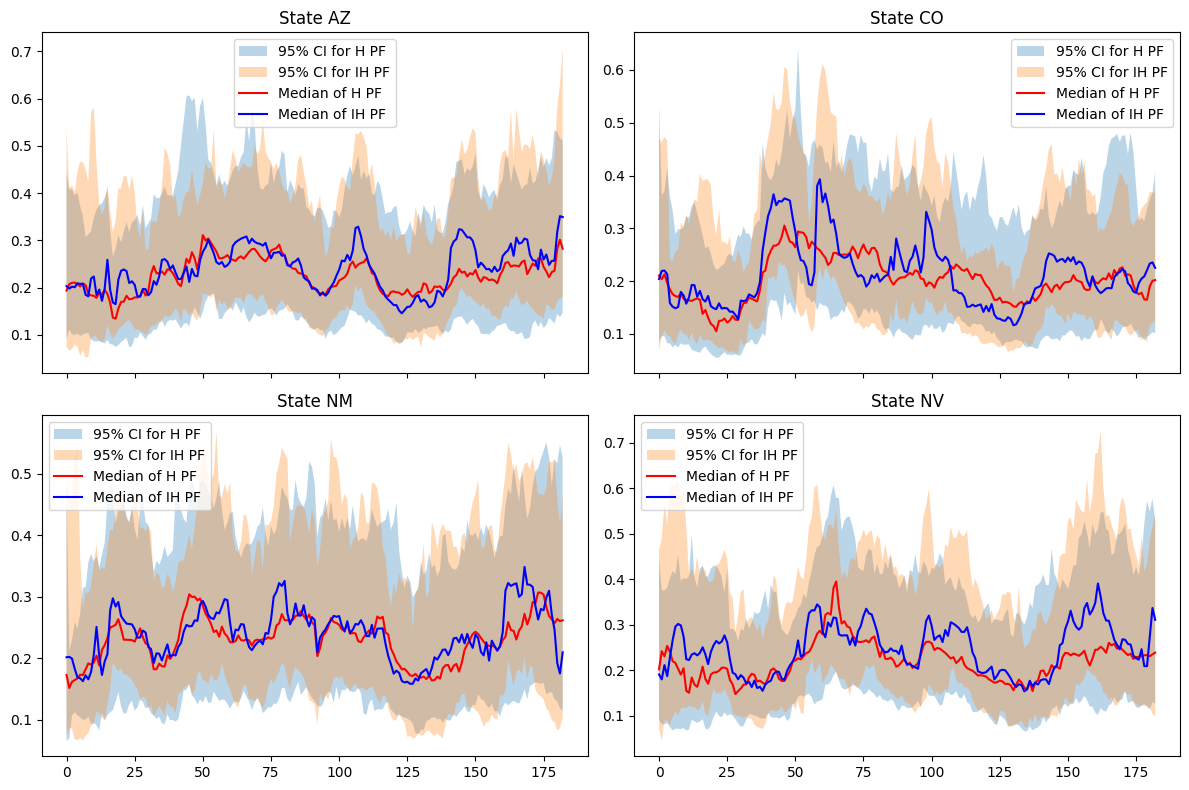

In [10]:
cols = 2

n = len(states)

rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()


for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower_H = np.percentile(particle_filter_output_H.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper_H = np.percentile(particle_filter_output_H.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()

    lower_IH = np.percentile(particle_filter_output_IH.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper_IH = np.percentile(particle_filter_output_IH.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()


    median_H  = np.median(particle_filter_output_H.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()
    median_IH  = np.median(particle_filter_output_IH.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()

    ax.fill_between(sim_date_range, np.exp(lower_H), np.exp(upper_H), alpha=0.3, label='95% CI for H PF')
    ax.fill_between(sim_date_range, np.exp(lower_IH), np.exp(upper_IH), alpha=0.3, label='95% CI for IH PF')
    ax.plot(sim_date_range, np.exp(median_H), color='red', label='Median of H PF')
    ax.plot(sim_date_range, np.exp(median_IH), color='blue', label='Median of IH PF')
    
    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

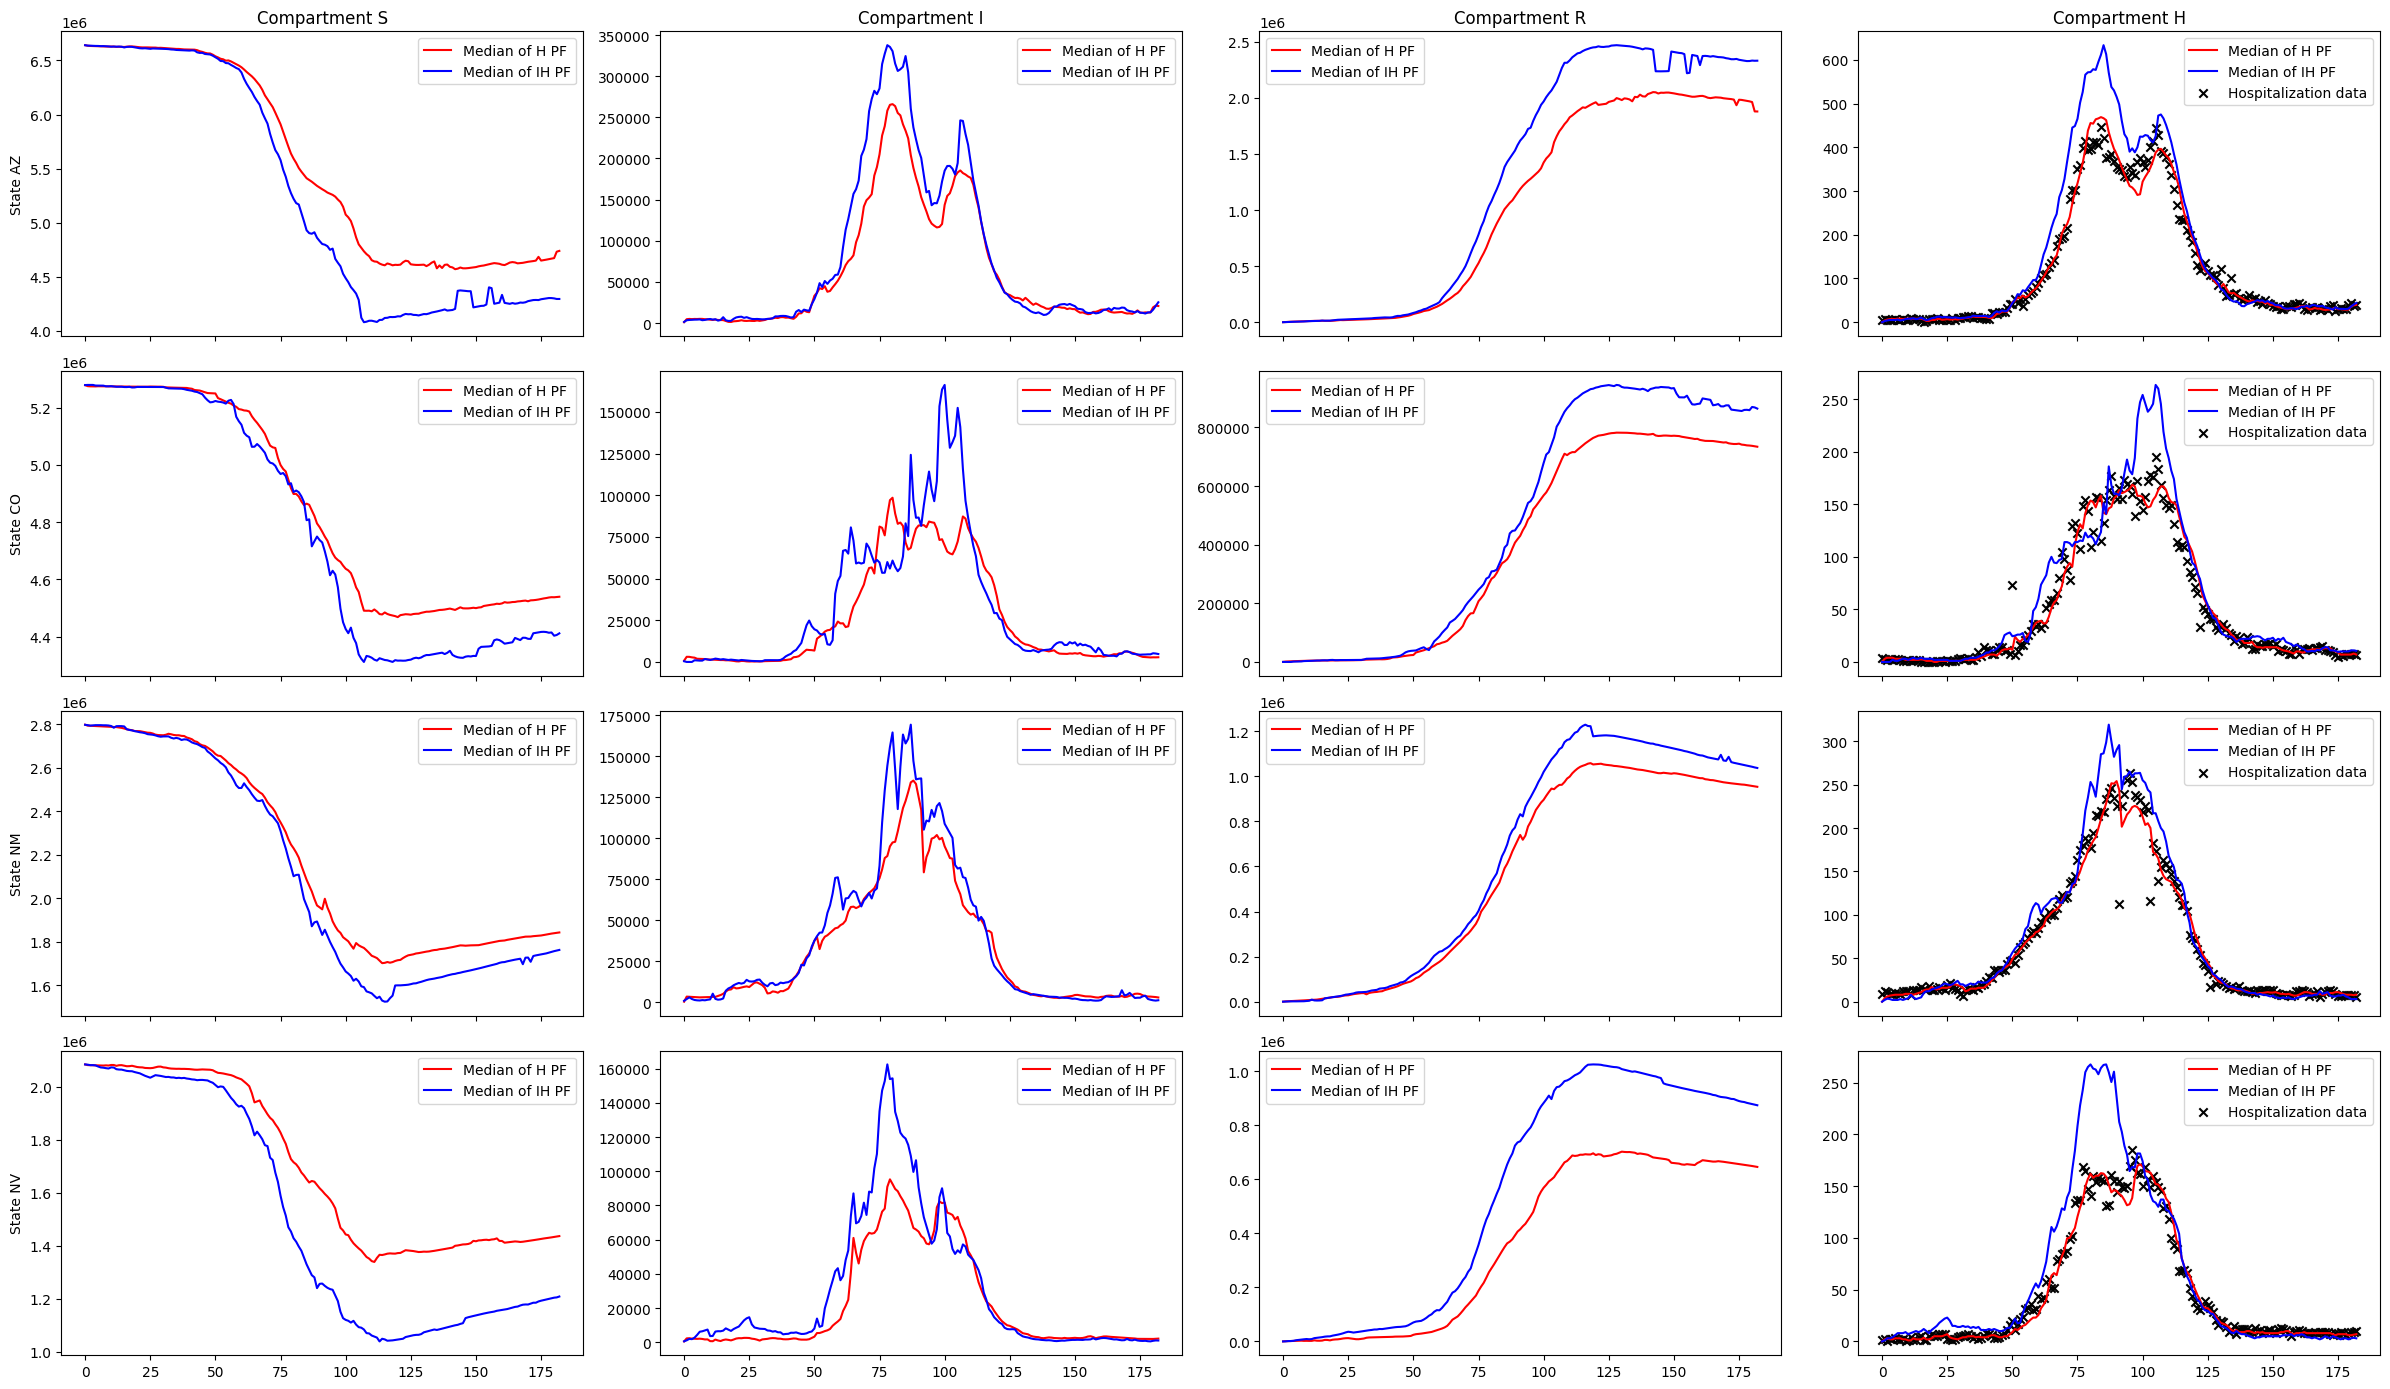

In [11]:
a = particle_filter_output_H.compartments.shape[3]
compartment_labels = ['S','I','R','H']

rows = n                      
cols = a                       

fig, axes = plt.subplots(rows, cols,
                         figsize=(6*cols, 3.5*rows),
                         sharex=True)


axes = np.atleast_2d(axes)

for i in range(n):             
    for k in range(a):         
        ax = axes[i, k]

        data_H = particle_filter_output_H.compartments[:, :, i, k]
        data_IH = particle_filter_output_IH.compartments[:, :, i, k]

        # lower_H = np.percentile(data_H, 2.5, axis=0).squeeze()
        # upper_H = np.percentile(data_H, 97.5, axis=0).squeeze()
        median_H  = np.median(data_H, axis=0).squeeze()

        # lower_IH = np.percentile(data_IH, 2.5, axis=0).squeeze()
        # upper_IH = np.percentile(data_IH, 97.5, axis=0).squeeze()
        median_IH  = np.median(data_IH, axis=0).squeeze()

        #ax.fill_between(sim_date_range, lower_H, upper_H, alpha=0.3,label = '95% CI for H PF')
        ax.plot(sim_date_range, median_H, color='red',label = 'Median of H PF')

        #ax.fill_between(sim_date_range, lower_IH, upper_IH, alpha=0.3,label = '95% CI for IH PF')
        ax.plot(sim_date_range, median_IH, color='blue',label = 'Median of IH PF')


        if k == 3:
            ax.scatter(sim_date_range,df[df['geoid'] == rume.scope.node_ids[i]]['value2'],color = 'black',marker = 'x',label = 'Hospitalization data')
        if i == 0:
            ax.set_title(f'Compartment {compartment_labels[k]}')
        if k == 0:
            ax.set_ylabel(f'State {states[i]}')

        ax.legend()

plt.tight_layout()
plt.show()


(100, 183, 4, 5)


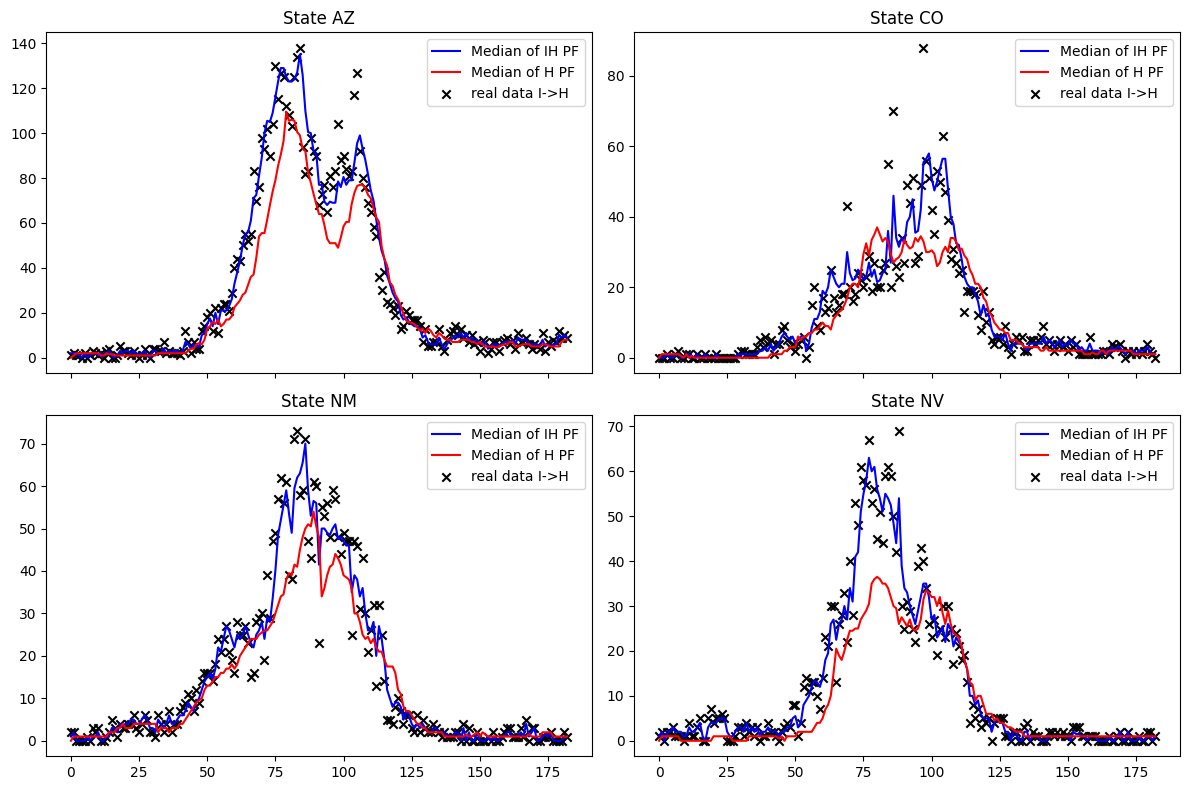

In [13]:
context = Context.of(
    scope=rume.scope,
    time_frame=rume.time_frame
)

real_data_result = (
    observations_IH.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(0,rume.time_frame.days,1)

n = len(states)
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

print(particle_filter_output_IH.events.shape)

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    median_IH  = np.median(particle_filter_output_IH.posterior_values[:, :, i, :], axis=1).squeeze()
    median_H  = np.median(particle_filter_output_H.events[:, :, i, 1], axis=0).squeeze()

    ax.plot(data_date_range, median_IH, color='blue', label='Median of IH PF')
    ax.plot(data_date_range, median_H, color='red', label='Median of H PF')
    ax.scatter(data_date_range,real_data[:,i],marker = 'x',color = 'black',label = 'real data I->H')
    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()